# **Problem**:

The goal is to solve the 2D Poisson equation on a square domain:

$$
-\Delta u = c, \quad \text{for } (x, y) \in [0, 1] \times [0, 1],
$$

where:
- \(u(x, y)\) is the scalar field to be computed.
- \(c\) is a positive constant source term.

The equation is subject to **Dirichlet boundary conditions**:

$$
u(x_b, y_b) = \gamma, \quad \text{for } (x_b, y_b) \text{ on the boundary of the domain}.
$$

In [ ]:
# HPC Class: Poisson's Equation
# Author: Aryan Eftekhari
# Email: aryan.eftkehari[at]usi.ch

# Import necessary libraries
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D
from matplotlib import cm

# Parameters
N       = 20                   # Number of grid points in each dimension
len_dom = 1.0                 # Length of the domain (assuming square domain)
dx      = len_dom / (N - 1)   # Grid spacing
c       = 20.0                # Source term (constant)
gamma   = 5

# Step 1: Discretize the domain
x = np.linspace(0, len_dom, N)
y = np.linspace(0, len_dom, N)
X, Y = np.meshgrid(x, y)


# **Finite Difference Stencil and Discretization**

To approximate the Laplacian operator $\Delta u$ in 2D, the continuous scalar field \(u(x, y)\) is discretized over a uniform grid. The domain $[0, 1] \times [0, 1]$ is divided into $N \times N$ points with spacings $\Delta x = \frac{L}{N-1}$ and $\Delta y = \frac{L}{N-1}$. The coordinates are discretized as:

$$
x_i = i \Delta x, \quad y_j = j \Delta y, \quad \text{for } i, j = 0, 1, \ldots, N-1.
$$

At each grid point $(i, j)$, the continuous function $u(x, y)$ is approximated as:

$$
u_{\,i,j} \approx u(x_i, y_j).
$$

### **Finite Difference Stencil**
To construct the operator matrix for a 2D grid using finite differences, we use a **5-point stencil**. The stencil approximates the Laplacian operator $\Delta u$ at each grid point $(i, j)$ as:
$$
{\left(\Delta u\right)}_{\,i,j} \approx \frac{-2u_{\,i,j} + u_{\,i+1,j} + u_{\,i-1,j}}{(\Delta x)^2} + \frac{-2u_{\,i,j} + u_{\,i,j+1} + u_{\,i,j-1}}{(\Delta y)^2}.
$$

For simplicity assume, $\Delta x = \Delta y = \Delta$, the expression simplifies to sume of **5** terms:
$$
{\left(\Delta u\right)}_{\,i,j} \approx \frac{1}{\Delta^2}(u_{\,i+1,j} + u_{\,i-1,j} + u_{\,i,j+1} + u_{\,i,j-1} - 4u_{\,i,j}).
$$

By ``collecting'' the grid points into a vector $\mathbf{u} = [u_{0,0}, u_{0,1}, u_{0,2}, \ldots, u_{\,N-1, N-1}]$, we can express the above equations as follows:
$$
\frac{-1}{\Delta^2} \mathbf{L} \mathbf{u} = \mathbf{b},
$$
where:
- $\mathbf{L}$ is a matrix of size $N^2 \times N^2$,  hoding the coieeffect of the 5-point stencil, referred to as the **Laplacian matrix**.
- $\mathbf{b}$ is a vector of size $N^2$, referred to as the **right-hand side vector**.

In [ ]:
## Laplacian Matrix Assembly

# Initialize lists for COO construction
row_indices  = []
col_indices  = []
data         = []
grid_vis     = np.empty((N, N), dtype=object)

# Fill the Laplacian matrix
for row in range(N):
    for col in range(N):
        index = row * N + col  # Flattened index for the current grid point

        # Diagonal element (-4)
        row_indices.append(index)
        col_indices.append(index)
        data.append(-4)
        grid_vis[row,col]=  "u["+str(row) + ',' + str(col)+"]"

        # left
        if col > 0:
            row_indices.append(index)
            col_indices.append(index - 1)
            data.append(1)

        # right
        if col < N - 1:
            row_indices.append(index)
            col_indices.append(index + 1)
            data.append(1)

        # top
        if row > 0:
            row_indices.append(index)
            col_indices.append(index - N)
            data.append(1)

        # bottom
        if row < N - 1:
            row_indices.append(index)
            col_indices.append(index + N)
            data.append(1)

# Create the COO matrix
L = sp.sparse.coo_matrix((data, (row_indices, col_indices)), shape=(N*N, N*N))

In [ ]:
## Laplacian Matrix and Grid Visualization

if N < 10:
  # Create a figure with subplots
  fig, axes = plt.subplots(1, 2, figsize=(8, 4),dpi=200)   # Two plots side by side

  # Plot the dense Laplacian matrix
  im = axes[0].imshow(L.todense(), cmap=cm.coolwarm, interpolation='nearest')
  cbar = plt.colorbar(im, ax=axes[0], shrink=0.5)  # shrink to make it smaller
  cbar.set_label("Matrix Values")
  axes[0].set_title("Laplacian Matrix")

  # Visualize the grid with labels
  axes[1].set_xticks(np.arange(N + 1) - 0.5, minor=True)
  axes[1].set_yticks(np.arange(N + 1) - 0.5, minor=True)
  axes[1].grid(which="minor", color="black", linestyle='-', linewidth=0.5)
  axes[1].tick_params(which="minor", size=1)
  for row in range(N):
      for col in range(N):
          axes[1].text(col, row, grid_vis[row, col], ha='center', va='center', fontsize=8)
  axes[1].set_xlim(-0.5, N - 0.5)
  axes[1].set_ylim(N - 0.5, -0.5)
  axes[1].set_aspect('equal')
  axes[1].set_title("Grid Visualization with Labels")

  # Adjust layout and display
  plt.tight_layout()
  plt.show()
else:
  print("N is too big ... will skip this")

N is too big ... will skip this


# **Graph Representation of the Finite Difference Operator**

The discrete finite difference operator for the 2D Laplacian can be represented as a **graph** where each nodal point $u_{\,i,j}$ is a node, and edges connect neighboring nodes. This graph highlights the connectivity of the computational grid and mirrors the finite difference stencil.

- **Nodes**: Represent grid points $u_{\,i,j}$.
- **Edges**: Connect neighboring nodes (left, right, top, bottom).
- **Structure**: Forms a regular grid graph, directly corresponding to a sparse matrix representation.


In [ ]:
if N < 10:

  # Convert the Laplacian matrix to an adjacency matrix
  adj_matrix = -L.tocsc()  # Negative Laplacian matrix to get adjacency
  adj_matrix.setdiag(0)  # Remove self-loops by zeroing the diagonal
  adj_matrix.eliminate_zeros()

  # Create a graph from the adjacency matrix
  G = nx.from_scipy_sparse_array(adj_matrix)

  # Create node positions for a 2D grid layout
  pos = {i: (i % N, i // N) for i in range(N * N)}  # Invert y-axis for better layout
  labels = {i: label for i, label in enumerate(grid_vis.flatten())}

  # Plot the graph
  fig, ax = plt.subplots(figsize=(4, 4), dpi=200)  # Adjust size and DPI for better rendering
  nx.draw(
      G,
      pos,
      labels=labels,
      with_labels=True,
      node_size=150,  # Increase node size
      node_color="skyblue",
      font_color="black",
      edge_color="gray",  # Make edges softer
      font_size=4,
      width=2,
  )

  # Set the title
  ax.set_title("Graph Representation of the Laplacian Matrix")
  plt.show()
else:
  print("N is too big ... will skip this")

N is too big ... will skip this


# **Assembling the RHS Vector** $\mathbf{b}$

To solve:
$$
\frac{-1}{\Delta^2} \mathbf{L} \mathbf{u} = \mathbf{b} \Rightarrow  \mathbf{L} \mathbf{u} = - \Delta^2 \mathbf{b}
$$

What if the boundary conditions (the value $\gamma$) is not zero (consider the corner node $u_{\,0,0}$)? We need to augment the $\mathbf{b}$ vector as
$$
(u_{\,i+1,j}  + u_{\,i,j+1}  - 4u_{\,i,j}) = - \Delta^2 b_{i,j} - u_{\,i,j-1} -  u_{\,i-1,j} .
$$



In [ ]:
# Initialize the RHS as a 2D array
B = -1 * np.full((N, N), c) * dx**2

# Apply boundary conditions (Dirichlet, for example: u=0 on the boundary)
B[0, :]  -= gamma  # Top boundary
B[-1, :] -= gamma  # Bottom boundary
B[:, 0]  -= gamma  # Left boundary
B[:, -1] -= gamma  # Right boundary

# Flatten the RHS to a 1D array
b = B.flatten()

# **Solve!**
Here we solve with the default (dense) Solver of ``numpy``.

In [ ]:
# Solve using numpy.linalg.solve
x = np.linalg.solve(L.todense(),b)


# **Visualize**
We plot the solution...




<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2414265753.py:11: SyntaxWarning: invalid escape sequence '\D'
  axes[0].set_title(f'$u(x,y)$ s.t. $-\Delta u = {c}$ and $\gamma={gamma}$')
/tmp/ipython-input-2414265753.py:11: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_title(f'$u(x,y)$ s.t. $-\Delta u = {c}$ and $\gamma={gamma}$')
/tmp/ipython-input-2414265753.py:18: SyntaxWarning: invalid escape sequence '\D'
  axes[1].set_title(f'$u(x,y)$ s.t. $-\Delta u = {c}$ and $\gamma={gamma}$')
/tmp/ipython-input-2414265753.py:18: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_title(f'$u(x,y)$ s.t. $

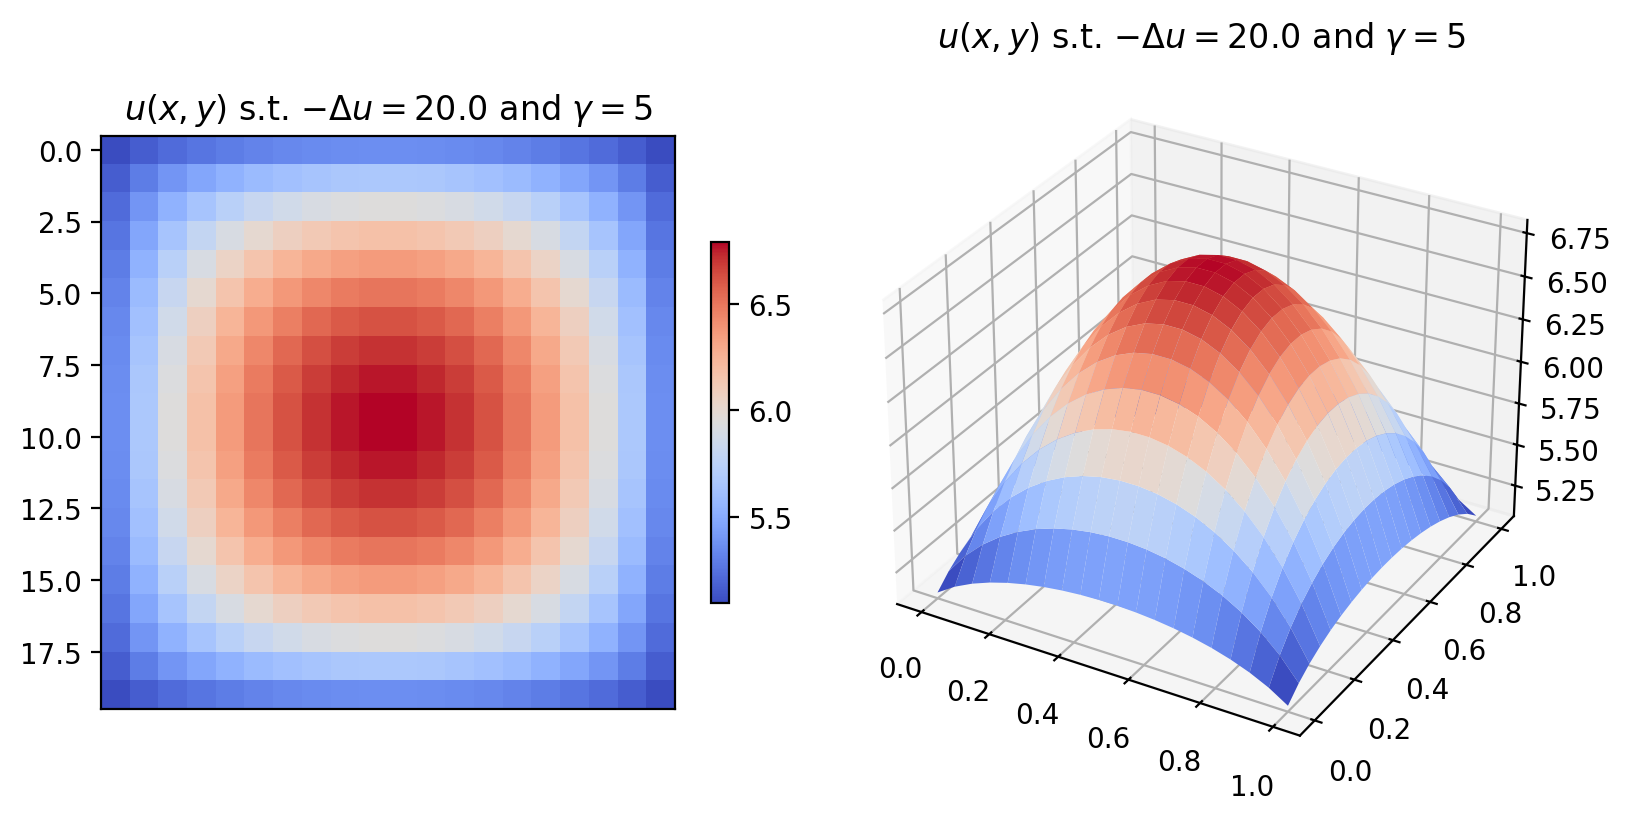

In [ ]:
# Reshape x back to 2D for visualization
X = x.reshape((N, N))

# Create a figure with two subplots
fig = plt.figure(figsize=(8, 4),dpi=200)   # Create a figure
axes = []

axes.append(fig.add_subplot(1, 2, 1))
im = axes[0].imshow(X, cmap=cm.coolwarm)
fig.colorbar(im, ax=axes[0],shrink=0.5)  # shrink to make it smaller
axes[0].set_title(f'$u(x,y)$ s.t. $-\Delta u = {c}$ and $\gamma={gamma}$')
axes[0].set_xticks([])

# 3D plot
axes.append(fig.add_subplot(1, 2, 2, projection='3d')) # add second subplot with projection='3d'
X_grid, Y_grid = np.meshgrid(np.linspace(0, 1.0, N), np.linspace(0, 1.0, N))
axes[1].plot_surface(X_grid, Y_grid, X, cmap=cm.coolwarm) # Now you can use plot_surface
axes[1].set_title(f'$u(x,y)$ s.t. $-\Delta u = {c}$ and $\gamma={gamma}$')

# Adjust layout and display
plt.tight_layout()
plt.show()